## ARMADA pipeline using orbitize

In [43]:
import numpy as np
import orbitize
from orbitize import driver,system,priors,sampler
from orbitize import read_input
import multiprocessing as mp
import os
from astropy.time import Time
from read_data import read_data,read_wds,read_orb6
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import string

%matplotlib inline

### First grab our ARMADA/WDS data to format it for orbitize

In [44]:
## select target, data
target = 'HD_45542'
data_armada = '/Users/tgardne/ARMADA_orbits/HD_45542_paper.txt'
data_wds = '/Users/tgardne/ARMADA_orbits/HD45542_chi2err/HD_45542_wds.txt'

#data_rv = '/Users/tgardne/ARMADA_orbits/HD45542_rv_paper.dat'

In [45]:
## read in armada data
file=open(data_armada)
weight=10
t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## read in wds data
file=open(data_wds)
weight=0.1
t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
file.close()

In [46]:
## read in rv
#file=open(data_rv)
#t_rv = []
#v = []
#verr = []
#for line in file.readlines():
#    if line.startswith('#'):
#        continue 
#    t_rv.append(float(line.split()[0])-2400000.5)
#    if line.split()[7]=='-':
#        v.append(np.nan)
#    else:
#        v.append(float(line.split()[7]))   
#    if line.split()[9]=='O':
#        verr.append(11)
#    else:
#        verr.append(3)
#file.close()

#weight=2

#v=np.asarray(v)
#verr=np.asarray(verr)*weight
#t_rv=np.asarray(t_rv)
#print(t_rv)

#plt.errorbar(t_rv,v,yerr=verr,fmt='o')
#plt.show()

In [47]:
## apply ETALON correction to armada data
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon_factor = 1  ##### COMMENT OUT TO APPLY CORRECTION!!!!!! #######
p = p/etalon_factor

xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)

Closest factor for 58026.5487 is 0.7676191089049098 days away
   date      etalon factor
58024.5609 1.0013913005492747
58026.5487 1.0011814421699845
58381.5053 0.9998481015009882
58443.462 0.9988046915708745
58456.3938 0.9981976158730872
58734.5365 1.0008714382436927
58769.5102 1.0007694647545562
58798.4763 1.000859060858182


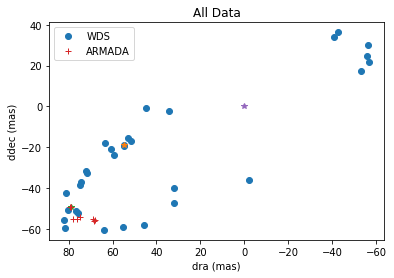

In [48]:
idx = np.argmin(t)
plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [49]:
## convert errors for orbitize
xerr = []
yerr = []
for i,j,k in zip(error_maj,error_min,error_deg):
    xerr1 = abs(i*np.sin(k*np.pi/180))
    xerr2 = abs(j*np.cos(k*np.pi/180))
    yerr1 = abs(i*np.cos(k*np.pi/180))
    yerr2 = abs(j*np.sin(k*np.pi/180))
    xerr.append(max(xerr1,xerr2))
    yerr.append(max(yerr1,yerr2))
xerr = np.array(xerr)
yerr = np.array(yerr)

xerr_wds = []
yerr_wds = []
for i,j,k in zip(error_maj_wds,error_min_wds,error_deg_wds):
    xerr1 = abs(i*np.sin(k*np.pi/180))
    xerr2 = abs(j*np.cos(k*np.pi/180))
    yerr1 = abs(i*np.cos(k*np.pi/180))
    yerr2 = abs(j*np.sin(k*np.pi/180))
    xerr_wds.append(max(xerr1,xerr2))
    yerr_wds.append(max(yerr1,yerr2))
xerr_wds = np.array(xerr_wds)
yerr_wds = np.array(yerr_wds)

print(xerr,yerr)
print(xerr_wds,yerr_wds)

[0.53       0.34894531 1.59       0.63223761 0.76855778 0.33339735
 0.23539011 0.34563229] [0.29       0.2152607  0.29       0.68203783 0.84197324 0.57854246
 0.25349704 0.31849383]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


In [50]:
## need to write to csv file for orbitize
f = open("/Users/tgardne/ARMADA_orbits/%s.csv"%target,"w+")
f.write("epoch object raoff raoff_err decoff decoff_err\r\n")

for i,j,k,l,m in zip(t_wds,xpos_wds,xerr_wds,ypos_wds,yerr_wds):
    f.write("%s 1 %s %s %s %s\r\n"%(i,j,k,l,m))
    
for i,j,k,l,m in zip(t,xpos,xerr,ypos,yerr):
    f.write("%s 1 %s %s %s %s\r\n"%(i,j,k,l,m))
    
#for i,j,k in zip(t_rv,v,verr):
#    f.write("%s 0 %s %s %s %s %s %s\r\n"%(i,np.nan,np.nan,np.nan,np.nan,j,k))

f.close()

### Now initiate an orbitize run

In [51]:
## set up data file
filename = "/Users/tgardne/ARMADA_orbits/%s.csv"%target.format(orbitize.DATADIR)
data_table = read_input.read_file(filename)
data_table.pprint_all()

      epoch        object        quant1            quant1_err            quant2            quant2_err     quant_type
------------------ ------ ------------------- ------------------- ------------------- ------------------- ----------
 43091.15671696002      1  54.795009907044715                 1.0 -19.013334512569656                 1.0      radec
 43092.17939512001      1  54.660943134858755                 1.0 -19.395393669831464                 1.0      radec
43174.943277640035      1   59.36695829931631                 1.0  -23.90741019615547                 1.0      radec
 43561.88086432009      1   74.38995160367796                 1.0  -36.81215968131252                 1.0      radec
 43941.84232498007      1   81.58353845913251                 1.0  -59.54096281122138                 1.0      radec
 44155.21681821998      1   80.37145100587351                 1.0  -50.65007268711938                 1.0      radec
 44294.95848394011      1   76.43549928879703                 1.

In [52]:
## select system parameters
num_secondary_bodies = 1
system_mass = 6 # [Msol]
plx = 5.99 # [mas]
mass_err = 1 # [Msol]
plx_err = 0 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

In [53]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err,
    tau_ref_epoch=0)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Gaussian]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


In [54]:
## change mtot to uniform
sys.sys_priors[lab['mtot']] = priors.UniformPrior(2,15)
#sys.sys_priors[lab['m0']] = 4.5

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)

## I find uniform prior better for semi-major
sys.sys_priors[lab['sma1']] = priors.UniformPrior(1,50)
#sys.sys_priors[lab['gamma']] = priors.UniformPrior(-50,50)
#sys.sys_priors[lab['sigma']] = priors.UniformPrior(-50,50)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Uniform]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


### Now Run the MCMC

In [55]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [56]:
## run the chains
total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 50 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encoun

Burn in complete
100/100 steps completed
Run complete


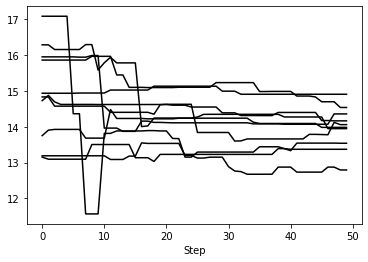

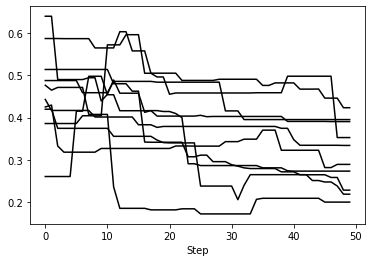

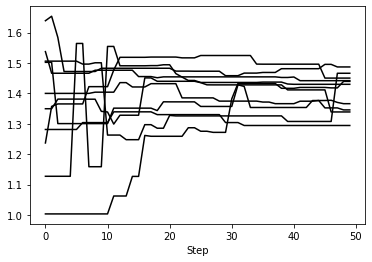

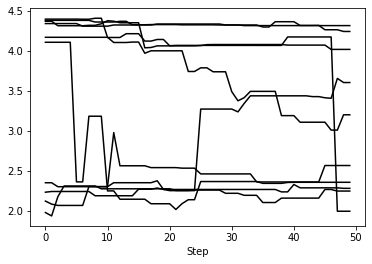

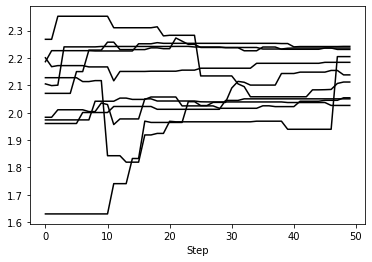

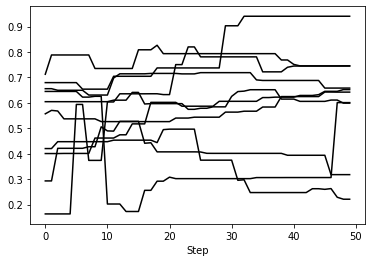

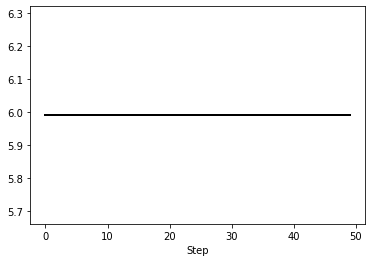

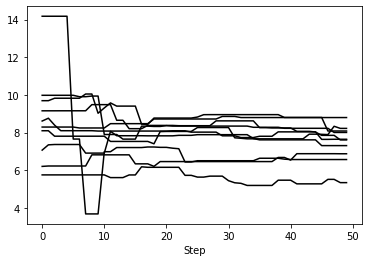

In [57]:
## example for how to look at chains:
#ecc_chains = my_driver.sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])
ecc_chains = mcmc_sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])

[14.28335373  0.38392203  1.39410944  3.92378468  2.08760337  0.56160906
  7.93384514]


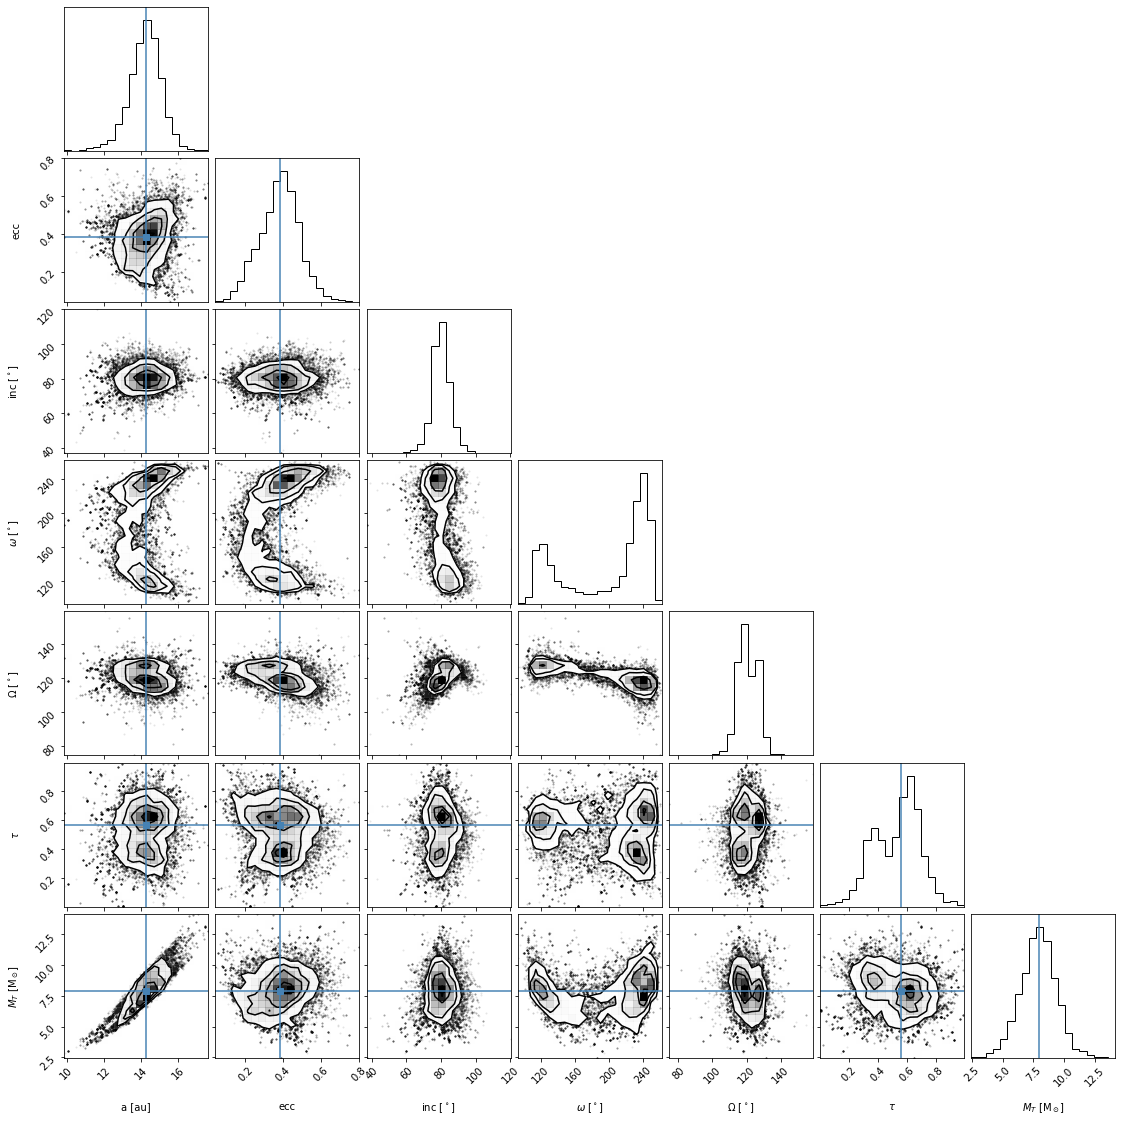

In [60]:
#corner_plot_fig = my_driver.sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot']) # Creates a corner plot and returns Figure object
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
#range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter

median_values = np.delete(median_values,6)
#range_values = np.delete(range_values,6)

print(median_values)

corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot'],
                                                  truths=median_values)#,range=range_values)
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner.png'%target) # This is matplotlib.figure.Figure.savefig()

/Users/tgardne/.conda/envs/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1008x432 with 0 Axes>

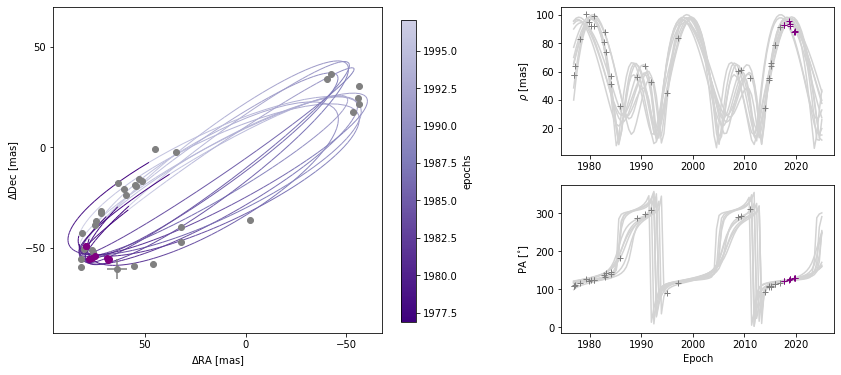

In [61]:
# plot orbits
#orb_fig = my_driver.sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100)
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=10)


ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear
epochs_wds = Time(t_wds, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
## add data to sep panel
ax_sep.plot(
    epochs_armada, p, '+',
    color='purple', zorder=4)
## add data to PA panel
ax_pa.plot(
    epochs_armada, theta*180/np.pi, '+',
    color='purple', zorder=4)
## add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

##### WDS #######
## add data to sep panel
ax_sep.plot(
    epochs_wds, p_wds, '+',
    color='grey', zorder=3)
## add data to PA panel
ax_pa.plot(
    epochs_wds, theta_wds*180/np.pi, '+',
    color='grey', zorder=3)
## add data to orbit panel
ax_orb.errorbar(
    xpos_wds, ypos_wds, xerr=xerr_wds, yerr=yerr_wds,
    color='grey', linestyle='', fmt='o', zorder=3)

orb_fig.show()

In [62]:
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
print(median_values)

period = np.sqrt(median_values[0]**3 / median_values[-1])
semi = median_values[0] * median_values[6]

print("Period = ", period, period*365.25)
print("a = ", semi)

[14.28335373  0.38392203  1.39410944  3.92378468  2.08760337  0.56160906
  5.99        7.93384514]
Period =  19.164761896048997 6999.929282531896
a =  85.55728884633935


## Include a second component!

In [352]:
## select system parameters
num_secondary_bodies = 2
m0 = 3.7 # [Msol]
plx = 12.85 # [mas]
mass_err = 0 # [Msol]
plx_err = 0 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

In [353]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err, fit_secondary_mass=True)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'sma2', 'ecc2', 'inc2', 'aop2', 'pan2', 'tau2', 'plx', 'm1', 'm2', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 12.85, Log Uniform, Log Uniform, 6.9]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'm1': 13, 'm2': 14, 'm0': 15}


In [354]:
## change mtot to uniform
#sys.sys_priors[lab['m0']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m1']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m2']] = priors.UniformPrior(0,10)

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)
sys.sys_priors[lab['pan2']] = priors.UniformPrior(0,np.pi)

## I find uniform prior better for semi-major
sys.sys_priors[lab['sma1']] = priors.UniformPrior(0,50)
sys.sys_priors[lab['sma2']] = priors.UniformPrior(0,50)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'sma2', 'ecc2', 'inc2', 'aop2', 'pan2', 'tau2', 'plx', 'm1', 'm2', 'm0']
[Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 12.85, Uniform, Uniform, 6.9]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'm1': 13, 'm2': 14, 'm0': 15}


In [355]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [356]:
## run the chains
total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 50 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encoun

Burn in complete
100/100 steps completed
Run complete


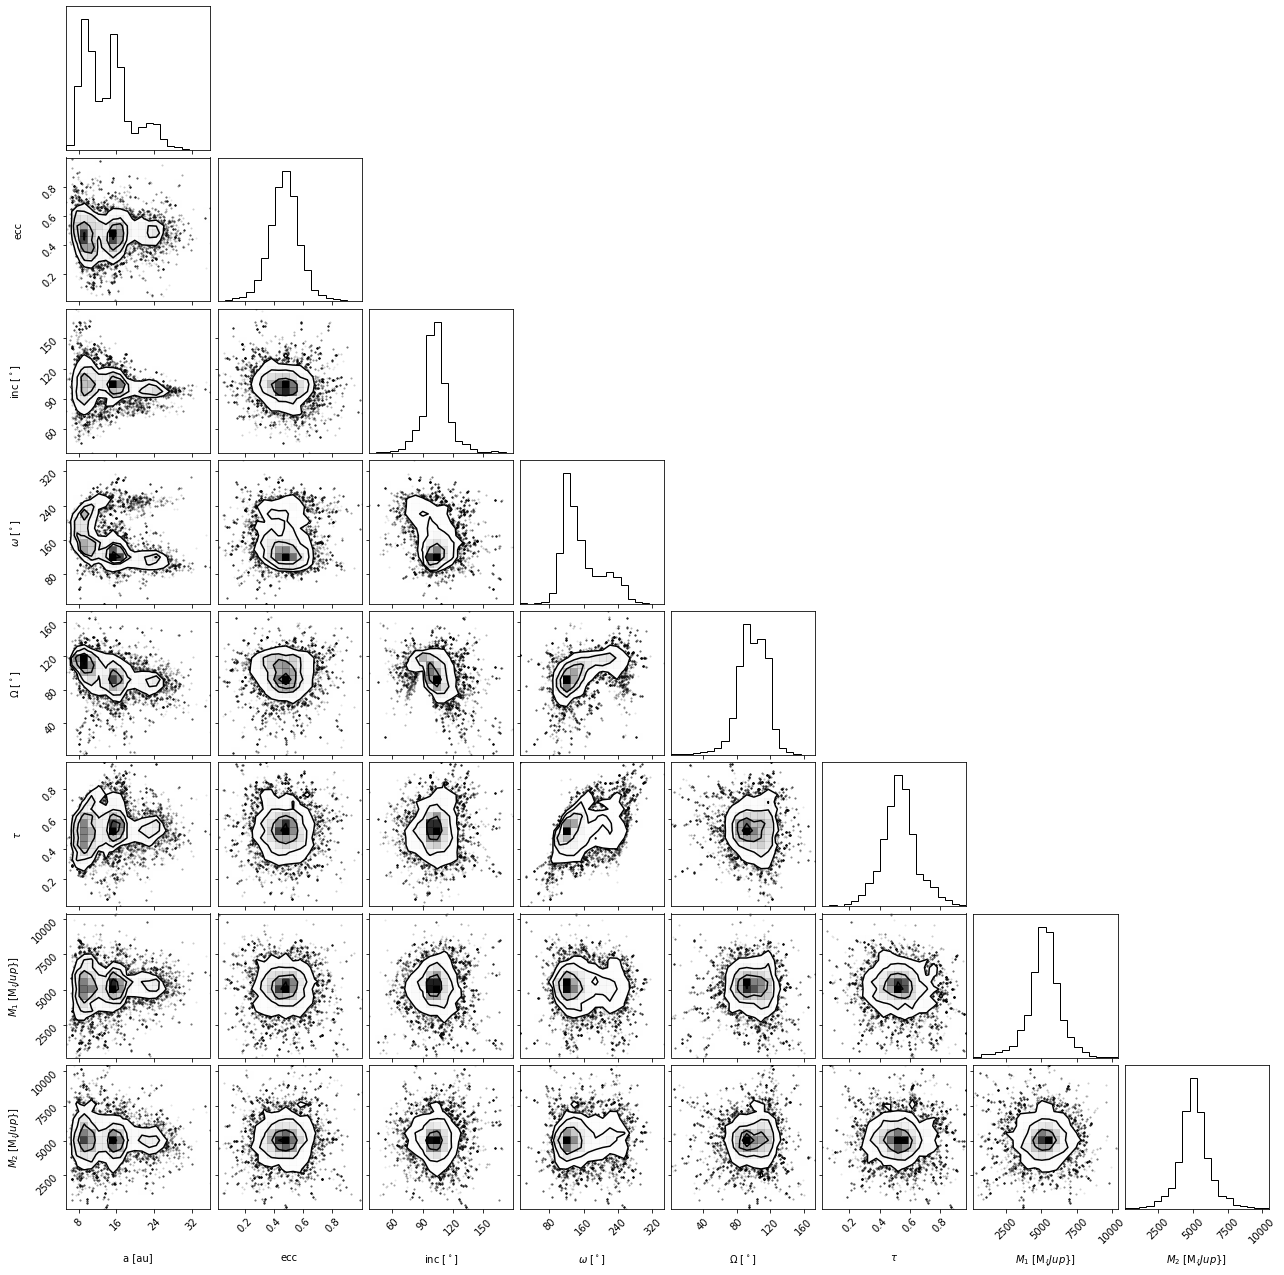

In [357]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'm1', 'm2'])
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_star.png'%target) # This is matplotlib.figure.Figure.savefig()

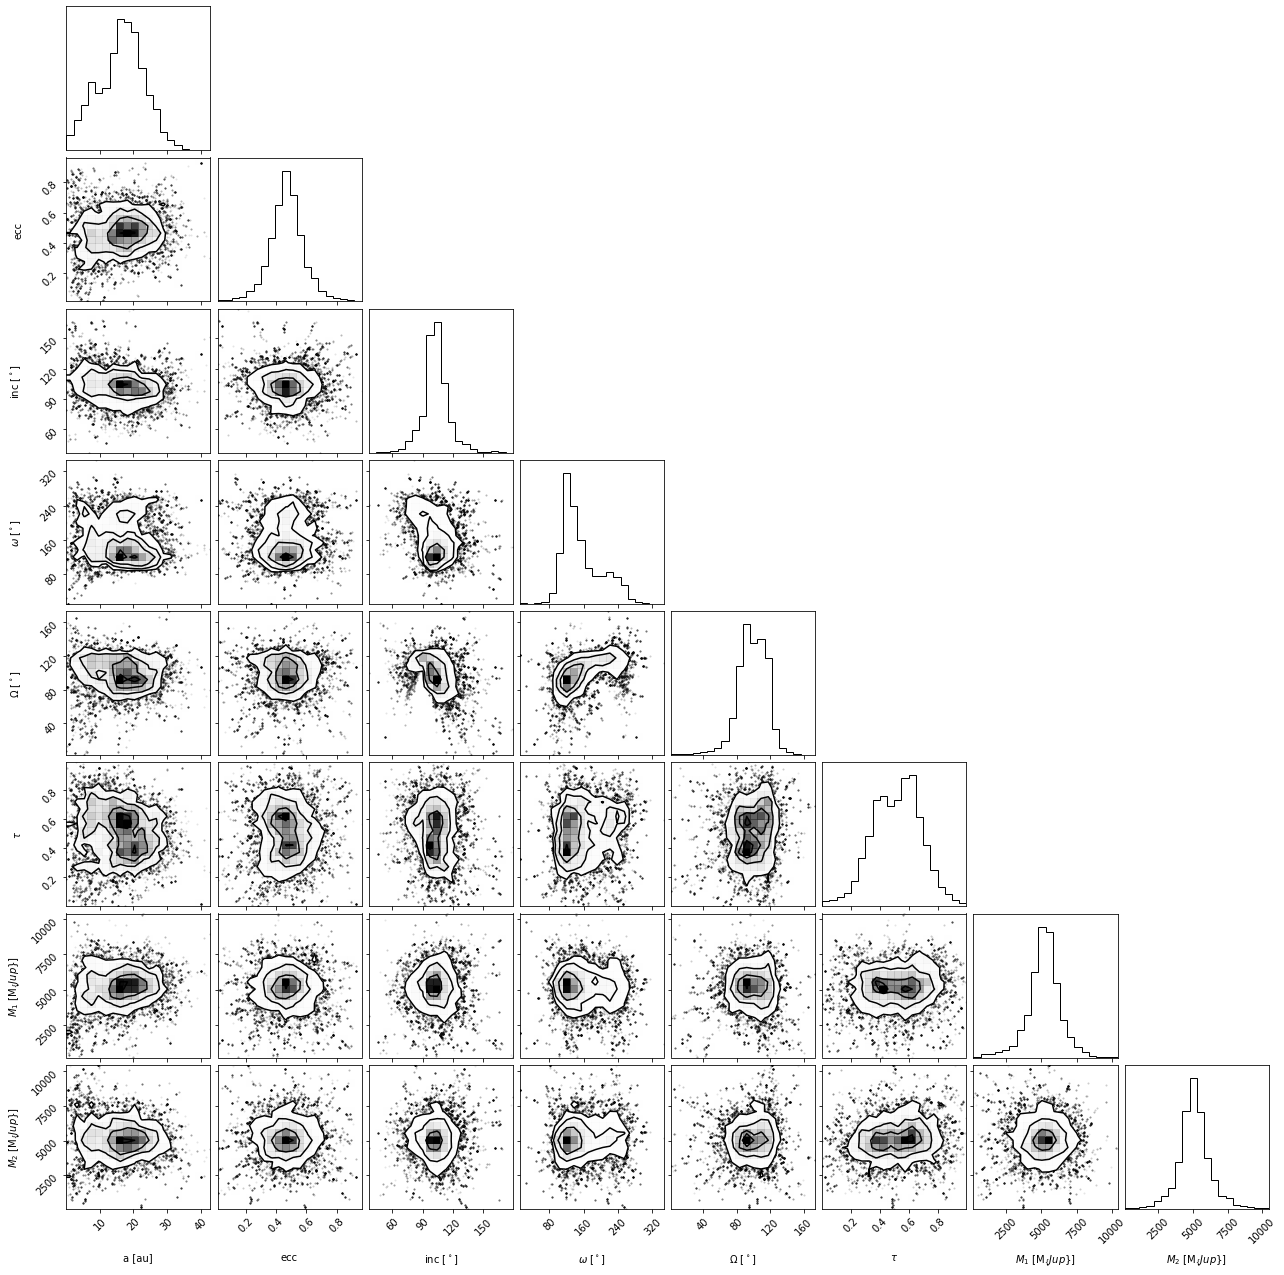

In [358]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma2', 'ecc2', 'inc2', 'aop2', 'pan2','tau2', 'm1', 'm2']) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_planet.png'%target) # This is matplotlib.figure.Figure.savefig()

/Users/tgardne/.conda/envs/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1008x432 with 0 Axes>

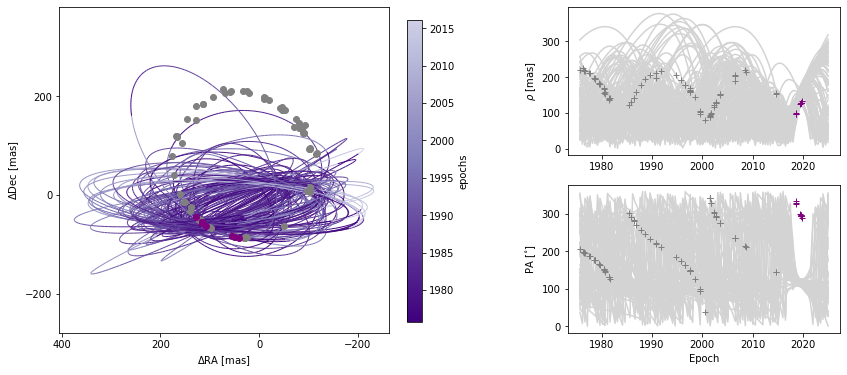

In [367]:
# plot orbits
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100, object_to_plot=1)
ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear
epochs_wds = Time(t_wds, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
## add data to sep panel
ax_sep.plot(
    epochs_armada, p, '+',
    color='purple', zorder=4)
## add data to PA panel
ax_pa.plot(
    epochs_armada, theta*180/np.pi, '+',
    color='purple', zorder=4)
## add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

##### WDS #######
## add data to sep panel
ax_sep.plot(
    epochs_wds, p_wds, '+',
    color='grey', zorder=3)
## add data to PA panel
ax_pa.plot(
    epochs_wds, theta_wds*180/np.pi, '+',
    color='grey', zorder=3)
## add data to orbit panel
ax_orb.errorbar(
    xpos_wds, ypos_wds, xerr=xerr_wds, yerr=yerr_wds,
    color='grey', linestyle='', fmt='o', zorder=3)

orb_fig.show()